In [5]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import math
import pandas as pd
import matplotlib as mpl

***Josh's functions***

In [2]:
def testNormal(input, alpha=0.05):
    if len(input) >= 20:
        #This function is based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality
        results = scipy.stats.normaltest(input) 
        p_values = results.pvalue
        normal_method = "D'Agostino-Pearson test (combined kurtosis + skewness)"
        if p_value > alpha: isnormal = True
        elif p_value <= alpha: isnormal = False
    else: 
        #For n<20, we have to rely on a Monte Carlo approach to test skew and kurtosis (kurtosistest is only valid n>=20) 
        rvs = lambda size: scipy.stats.norm.rvs(size=size, random_state=np.random.default_rng())
        skew_results = scipy.stats.monte_carlo_test(input, rvs, scipy.stats.skew, vectorized=True)
        kurtosis_results = scipy.stats.monte_carlo_test(input, rvs, scipy.stats.kurtosis, vectorized=True)
        p_values = [skew_results.pvalue, kurtosis_results.pvalue]
        normal_method = "Monte Carlo method (Fisher kurtosis + Fisher-Pearson skewness)"
        # data is only treated as normal if it has both normal skew and kurtosis
        if p_values[0] > 0.05 and p_values[1] > alpha: isnormal = True
        else: isnormal = False
    return isnormal, p_values, normal_method

def NC_StatGraph_new(data_df, side_or_huddle, metric='prop', na_column = "Unknown_sec", mode = 'paired', show_plot=True, print_ps = True, show_ps = True, print_means = False, saveFig = False, figName = 'test.png', savePath = ''):
    # e.g. NC_StatGraph(NC_chambertime,'side',mode='paired')
    # e.g. NC_side = NC_StatGraph(NC_chambertime,'huddle',mode='index')
    # metric can be 'ct' (count), 'lat' (latency), 'prop' (proportion), or 'sec' (seconds) but defaults to proportions
    
    #### Setting basic parameters based on inputs ####
    if side_or_huddle == 'side' or side_or_huddle == 'chamber': 
        wt_col = 'WT_'+metric
        het_col = 'HT_'+metric
        side_or_huddle_word = 'Chamber'
    elif side_or_huddle == 'huddle':
        wt_col = 'Huddle_WT_'+metric
        het_col = 'Huddle_HT_'+metric 
        side_or_huddle_word = 'Huddle'


    #### Exclude rows that don't meet NA criteria and are sex-specific
    male_df = pd.DataFrame({'WT': data_df[(data_df['Het_Sex']=='M')& (data_df[na_column]<60)][wt_col], 
                            'Het': data_df[(data_df['Het_Sex']=='M')& (data_df[na_column]<60)][het_col]})
    female_df = pd.DataFrame({'WT': data_df[(data_df['Het_Sex']=='F')& (data_df[na_column]<60)][wt_col], 
                              'Het': data_df[(data_df['Het_Sex']=='F')& (data_df[na_column]<60)][het_col]})

    #### Setting color schemes and labels based on sex ####
    
    acols = [[0.627451,   0.57254905, 0.37254903], # all colors
        [0.9607843,  0.7882353,  0.15294118],
        [0.34901962, 0.35686275, 0.49019608],
        [0.24705882, 0.30588236, 0.9607843 ]]

    fcols = acols[0:2] # female colors, WT first
    mcols = acols[2:] # male colors, WT first    
    
    if mode == 'paired': ### Four column situation with lines
        #### Setting basic parameters based on inputs ####
        #if side_or_intxn == 'side': y_max = 1.3
        #elif side_or_intxn == 'intxn' or side_or_intxn == 'interact' or side_or_intxn == 'interaction': y_max = 1.15

        #### Stats ####
        #### Testing for normality via skew and kurtosis (normaltest for n>=20, monte carlo for n<20) ####
        mwt_norm = testNormal(male_df['WT'])[0]
        mhet_norm = testNormal(male_df['Het'])[0]
        fwt_norm = testNormal(female_df['WT'])[0]
        fhet_norm = testNormal(female_df['Het'])[0]
        
        normal_test = [mwt_norm, mhet_norm, fwt_norm, fhet_norm]

        #### paired tests: paired-t-test, wilcoxon signed-rank ####
        if mwt_norm == True and mhet_norm == True: 
            m_stat, m_p = scipy.stats.ttest_ind(male_df['WT'], male_df['Het'])
            m_test = 'independent t-test'
        else: 
            m_stat, m_p = scipy.stats.mannwhitneyu(male_df['WT'], male_df['Het'])
            m_test = 'mann-whitney u test'
            
        if fwt_norm == True and fhet_norm == True: 
            f_stat, f_p = scipy.stats.ttest_ind(female_df['WT'], female_df['Het'])
            f_test = 'independent t-test'
        else: 
            f_stat, f_p = scipy.stats.mannwhitneyu(female_df['WT'], female_df['Het'])
            f_test = 'mann-whitney u test'
        
        ps = [m_p, f_p] #stim_p, obj_p]
        p_statements = ['Male WT vs Male Het ','Female WT vs Female Het ']#, 'WT vs Het animal ', 'WT vs Het object ']
        stat_tests = [m_test, f_test] #stim_test, obj_test]

        #### Plotting ####
        if show_plot == True:

            # make dfs for jittered x-values (made of random numbers around +/-0.05) with same same column labels as original df
            jitter = 0.05
            df_m_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=male_df.values.shape), columns=male_df.columns,index = male_df.index)
            df_m_jitter += [0,1] # wt columns are jittered around 0 and 1 (animal and object, respectively)
            df_f_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=female_df.values.shape), columns=female_df.columns,index = female_df.index)
            df_f_jitter += [2,3] # het columns are jittered around 2 and 3 (animal and object, respectively)

            # Plot points and bars for wt and het dfs with appropriate colors and labels
            fig, ax = plt.subplots()
            for df, df_jitter, cols, wt_x in zip([male_df,female_df],[df_m_jitter,df_f_jitter],[mcols,fcols],[0,2]):
                ax.plot(df_jitter['WT'], df['WT'], 'o', markerfacecolor=cols[0] , markeredgecolor =cols[0],zorder=1, ms=5, mew=1, alpha = 1)
                ax.bar(wt_x, np.mean(df['WT']), color = cols[0], edgecolor = 'none', yerr = scipy.stats.sem(df['WT']), 
                       ecolor = 'k', capsize = 5,linewidth = 1, zorder=-1, alpha = 0.5, label=('WT'))
                ax.plot(df_jitter['Het'], df['Het'], 'o', markerfacecolor=cols[1] , markeredgecolor =cols[1],zorder=1, ms=5, mew=1, alpha = 1)
                ax.bar(wt_x+1, np.mean(df['Het']), color = cols[1], edgecolor = 'none', yerr = scipy.stats.sem(df['Het']), 
                       ecolor = 'k', capsize = 5,linewidth = 1, zorder=-1, alpha = 0.5, label=('Het'))
                
            ax.set_xticks([0,1,2,3]) 
            ax.set_xticklabels(['M WT', 'M Het', 'F WT', 'F Het']) # labels 0-3 with appropriate column name
            ax.set_xlim(-0.5,3.5) # set x limits to column +/- 0.5
        
            y_max = np.max([np.max(male_df[col]) for col in male_df.columns] + [np.max(female_df[col]) for col in female_df.columns])
            if metric == 'prop':
                ax.set_ylim(0,1.17) # set y limits
                ax.set_ylabel('Proportion of Assay')
                ax.set_title('Scn2a Naive Choice ('+side_or_huddle_word+')')
            elif metric == 'sec':
                ax.set_ylim(0,1.17*y_max) # set y limits
                ax.set_ylabel('Total duration (seconds)')
                ax.set_title('Scn2a Naive Choice ('+side_or_huddle_word+')')
            elif metric == 'ct':
                ax.set_ylim(0,1.17*y_max) # set y limits
                ax.set_ylabel('Count')
            elif metric == 'lat':
                ax.set_ylim(0,1.17*y_max) # set y limits
                ax.set_ylabel('Latency (seconds)')
                ax.set_title('Scn2a Naive Choice ('+side_or_huddle_word+ ' latency)')
            
            ax.set_xlabel('Stimulus Sex/Genotype')
            fig.set_figwidth(7)

            # Plot connecting lines
            for idx in male_df.index: ax.plot(df_m_jitter.loc[idx,['WT','Het']], male_df.loc[idx,['WT','Het']], color = 'k', linewidth = 0.5, linestyle = '-', zorder=-1)
            for idx in female_df.index: ax.plot(df_f_jitter.loc[idx,['WT','Het']], female_df.loc[idx,['WT','Het']], color = 'k', linewidth = 0.5, linestyle = '-', zorder=-1)

            # Make p-labels
            p_labels = ['label0','label1']#,'label2','label3']
            for i in range(len(ps)):
                if ps[i] < 0.01: 
                    p_formatted = np.format_float_scientific(ps[i], unique=False, precision=3)
                    if ps[i]< 0.001: p_label = '***'
                    else: p_label = '**'
                elif ps[i] >= 0.01: 
                    p_formatted = str(round(ps[i], 3))
                    if ps[i]<=0.05: p_label = '*'
                    else: p_label = 'n.s.'
                p_labels[i] = p_label
                if print_ps == True: 
                    print(p_statements[i] + side_or_huddle_word.lower() + ': p = ' + p_formatted + ', ' + stat_tests[i])

            # Define p-value bar values
            p_color = ['color0','color1']#,'color2','color3']
            for p_val, i in zip(ps,[0,1]):#,2,3]):
                if p_val>=0.05: p_color[i] = 'lightgray'
                elif p_val<0.05: p_color[i] = 'k'
            
            if metric == 'prop':
                if np.max([np.max(male_df['WT']),np.max(male_df['Het'])]) >= 0.89: m_y_bar = 1.01
                else: m_y_bar = np.max([np.max(male_df['WT']),np.max(male_df['Het'])]) + 0.12 
                if np.max([np.max(female_df['WT']),np.max(female_df['Het'])]) >= 0.89: f_y_bar = 1.01
                else: f_y_bar = np.max([np.max(female_df['WT']),np.max(female_df['Het'])]) + 0.12
            else:
                m_y_bar = np.max([np.max(male_df['WT']),np.max(male_df['Het'])]) * 1.12
                f_y_bar = np.max([np.max(female_df['WT']),np.max(female_df['Het'])]) * 1.12
            
            
            if show_ps == True:
                # Plot p-labels
                ax.plot([0,1],[m_y_bar,m_y_bar],color = p_color[0], linewidth = 1, linestyle = '-', zorder=1)
                ax.text(0.5, m_y_bar*1.02, p_labels[0], fontsize=10,ha='center',color = p_color[0])
                ax.plot([2,3],[f_y_bar,f_y_bar],color = p_color[1], linewidth = 1, linestyle = '-', zorder=1)
                ax.text(2.5, f_y_bar*1.02, p_labels[1], fontsize=10,ha='center',color = p_color[1])
                
                #ax.plot([0,2],[np.max([wt_y_bar,het_y_bar])+0.1,np.max([wt_y_bar,het_y_bar])+0.1],color = p_color[2], linewidth = 1, linestyle = '-', zorder=1)   
                #ax.text(1, np.max([wt_y_bar,het_y_bar])+0.11, p_labels[2], fontsize=10,ha='center',color = p_color[2])
                #ax.plot([1,3],[np.max([wt_y_bar,het_y_bar])+0.2,np.max([wt_y_bar,het_y_bar])+0.2],color = p_color[3], linewidth = 1, linestyle = '-', zorder=1)   
                #ax.text(2, np.max([wt_y_bar,het_y_bar])+0.21, p_labels[3], fontsize=10,ha='center',color = p_color[3])

            if saveFig == True: plt.savefig((savePath + figName))
            plt.show() 

        means = [np.mean(male_df['WT']), np.mean(male_df['Het']), np.mean(female_df['WT']), np.mean(female_df['Het'])]
        sems = [scipy.stats.sem(male_df['WT']), scipy.stats.sem(male_df['Het']), scipy.stats.sem(female_df['WT']), scipy.stats.sem(female_df['Het'])]
        if print_means == True: 
            for sex_word, stim_geno, i in zip(['Male','Male','Female','Female'],['WT','Het','WT','Het'],[0,1,2,3]):
                print(sex_word + ' ' + stim_geno + ' ' +side_or_intxn_word.lower() + ' = ' + str(round(means[i], 2)) + '±' + str(round(sems[i], 2)))
    
    elif mode == 'index' or mode == 'idx' or mode == 'Index':
        prefIndex_M = pd.DataFrame({'prefIdx': data_df[(data_df['Het_Sex']=='M')& (data_df[na_column]<60)]['Huddle_geno_PI']})
        prefIndex_F = pd.DataFrame({'prefIdx': data_df[(data_df['Het_Sex']=='F')& (data_df[na_column]<60)]['Huddle_geno_PI']})

        # normality test
        m_pi_norm = testNormal(prefIndex_M['prefIdx'])[0]
        f_pi_norm = testNormal(prefIndex_F['prefIdx'])[0]
        normal_test = [m_pi_norm, f_pi_norm]

        #### tests against 0 null: t-test or wilcoxon ####
        if m_pi_norm == True:
            m_res = scipy.stats.ttest_1samp(prefIndex_M['prefIdx'], popmean = 0)
            m_p = m_res.pvalue
            m_test = '1-sample t-test, null = 0'
        else:     
            m_stat, m_p = scipy.stats.wilcoxon(prefIndex_M['prefIdx'], zero_method = 'pratt')
            m_test = 'wilcoxon signed-rank test'
        if f_pi_norm == True:
            f_res = scipy.stats.ttest_1samp(prefIndex_F['prefIdx'], popmean = 0)
            f_p = m_res.pvalue
            f_test = '1-sample t-test, null = 0'
        else:     
            f_stat, f_p = scipy.stats.wilcoxon(prefIndex_F['prefIdx'], zero_method = 'pratt')
            f_test = 'wilcoxon signed-rank test'


        #### independent tests: t-test or mann-whitney ####
        #if wt_pi_norm == True and het_pi_norm == True: 
       #     prefIdx_stat, prefIdx_p = scipy.stats.ttest_ind(prefIndex_wt['prefIndex'], prefIndex_het['prefIndex'])
        #    prefIdx_test = 'independent samples t-test'
        #else: 
         #   prefIdx_stat, prefIdx_p = scipy.stats.mannwhitneyu(prefIndex_wt['prefIndex'], prefIndex_het['prefIndex']) 
          #  prefIdx_test = 'mann-whitney u test'   

        ps = [m_p, f_p]#, prefIdx_p]
        p_statements = [('Male '+'Huddle'+' Index vs 0:'),('Female '+'Huddle'+' Index vs 0:')]#,('WT vs Het '+side_or_intxn_idx_word+' Index:')]
        stat_tests = [m_test, f_test]#, prefIdx_test]
        
        if show_plot == True: 
            
            jitter = 0.05
            df_m_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=prefIndex_M.values.shape), columns=prefIndex_M.columns)
            df_m_jitter += 0 # wt columns are jittered around 0 
            df_f_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=prefIndex_F.values.shape), columns=prefIndex_F.columns)
            df_f_jitter += 1 # het columns are jittered around 1

            # Plot points and bars for wt and het dfs with appropriate colors and labels
            fig, ax = plt.subplots()
            mcol_ave = [np.average([col1,col2]) for col1,col2 in zip(mcols[0],mcols[1])]
            ax.plot(df_m_jitter['prefIdx'], prefIndex_M['prefIdx'], 'o', markerfacecolor=mcol_ave , markeredgecolor=mcol_ave,zorder=1, ms=5, mew=1)
            ax.bar(0, np.mean(prefIndex_M['prefIdx']), color = mcol_ave, edgecolor = 'none', yerr = scipy.stats.sem(prefIndex_M['prefIdx']), ecolor = 'k', 
                   capsize = 5,linewidth = 1, zorder=-1, alpha = 0.5)

            fcol_ave = [np.average([col1,col2]) for col1,col2 in zip(fcols[0],fcols[1])]
            ax.plot(df_f_jitter['prefIdx'], prefIndex_F['prefIdx'], 'o', markerfacecolor=fcol_ave , markeredgecolor=fcol_ave,zorder=1, ms=5, mew=1)
            ax.bar(1, np.mean(prefIndex_F['prefIdx']), color = fcol_ave, edgecolor = 'none', yerr = scipy.stats.sem(prefIndex_F['prefIdx']), ecolor = 'k', 
                   capsize = 5,linewidth = 1, zorder=-1, alpha = 0.5)
            
            ax.axhline(y=0, color='k', linestyle='-',zorder=1)
            ax.set_xticks([0, 1]) 
            ax.set_xticklabels([' Male',' Female']) 
            ax.set_xlim(-0.5,1.5) # set x limits to column +/- 0.5
            ax.set_ylabel('Preference Index (WT = 1, Het = -1')
            ax.set_xlabel('Stimulus Sex')
            ax.set_ylim(-1.2,1.2) # set y limits
            ax.set_title('Scn2a Naive Choice Huddle Preference Index')
            fig.set_figwidth(4)

            # Make p-labels
            p_labels = ['label0', 'label1']#, 'label2']
            for i in range(len(ps)):   
                if ps[i] < 0.01: 
                    p_formatted = np.format_float_scientific(ps[i], unique=False, precision=3)
                    if ps[i]< 0.001: p_label = '***'
                    else: p_label = '**'
                elif ps[i] >= 0.01: 
                    p_formatted = str(round(ps[i], 3))
                    if ps[i]<=0.05: p_label = '*'
                    else: p_label = 'n.s.'
                p_labels[i] = p_label
                if print_ps == True: print(p_statements[i] +' p = ' + p_formatted + ', ' + stat_tests[i])

            # Define p-value bar values
            p_color = ['color0', 'color1']#, 'color2']
            for p_val, i in zip(ps,[0,1,]):#2]):
                if p_val>=0.05: p_color[i] = 'lightgray'
                elif p_val<0.05: p_color[i] = 'k'
            if np.max([np.max(prefIndex_M['prefIdx']),np.max(prefIndex_F['prefIdx'])]) >= 0.94: y_bar = 1.0
            else: y_bar = np.max([np.max(prefIndex_M['prefIdx']),np.max(prefIndex_F['prefIdx'])]) + 0.06

            if show_ps == True:
                # Plot p-labels
                ax.text(0, y_bar+0.01, p_labels[0], fontsize=10, ha='center',color = p_color[0])
                ax.text(1, y_bar+0.01, p_labels[1], fontsize=10, ha='center',color = p_color[1])
                #ax.plot([0,1],[y_bar+0.11,y_bar+0.11],color = p_color[2], linewidth = 1, linestyle = '-', zorder=1)
                #ax.text(0.5, y_bar+0.13, p_labels[2], fontsize=10, ha='center',color = p_color[2])
            if saveFig == True: plt.savefig((savePath + figName))
            plt.show()

        means = [np.mean(prefIndex_M['prefIdx']), np.mean(prefIndex_F['prefIdx'])]
        sems = [scipy.stats.sem(prefIndex_M['prefIdx']), scipy.stats.sem(prefIndex_F['prefIdx'])]

        if print_means == True: 
            print('Male Left/Right Huddle Preference Index = ' + str(round(means[0], 2)) + '±' + str(round(sems[0], 2)))
            print('Female Left/Right Huddle Preference Index = ' + str(round(means[1], 2)) + '±' + str(round(sems[1], 2)))

    return means, sems, ps, p_statements, stat_tests, normal_test

def NC_SideBiasGraph_new(data_df, side_or_huddle, mode = 'paired', metric = 'prop',na_column = "Unknown_sec", show_plot=True, print_ps = True, show_ps = True, print_means = False, saveFig = False, figName = 'test.png', savePath = ''):
    # e.g. NC_StatGraph(NC_chambertime,'side',mode='paired')
    # e.g. NC_side = NC_StatGraph(NC_chambertime,'huddle',mode='index')
    
    #### Setting basic parameters based on inputs ####
    if side_or_huddle == 'side' or side_or_huddle == 'chamber': 
        left_col = 'Left_'+metric
        right_col = 'Right_'+metric
        side_or_huddle_word = 'Chamber'
    elif side_or_huddle == 'huddle':
        left_col = 'Huddle_Left_'+metric
        right_col = 'Huddle_Right_' +metric 
        side_or_huddle_word = 'Huddle'


    #### Exclude rows that don't meet NA criteria and are sex-specific
    male_rows = data_df[(data_df['Het_Sex']=='M')& (data_df[na_column]<60)]
    male_df = pd.DataFrame({'Left': male_rows[left_col], 'Right': male_rows[right_col]})
    
    female_rows = data_df[(data_df['Het_Sex']=='F')& (data_df[na_column]<60)]
    female_df = pd.DataFrame({'Left': female_rows[left_col], 'Right': female_rows[right_col]})
    #### Setting color schemes and labels based on sex ####
    
    acols = [[0.627451,   0.57254905, 0.37254903], # all colors
        [0.9607843,  0.7882353,  0.15294118],
        [0.34901962, 0.35686275, 0.49019608],
        [0.24705882, 0.30588236, 0.9607843 ]]
    fcols = acols[0:2] # female colors, WT first
    mcols = acols[2:] # male colors, WT first
    m_average = [np.average([color1,color2]) for color1,color2 in zip(mcols[0], mcols[1])]
    f_average = [np.average([color1,color2]) for color1,color2 in zip(fcols[0], fcols[1])]
    
    if mode == 'paired': ### Four column situation with lines
        
        #### Stats ####
        #### Testing for normality via skew and kurtosis (normaltest for n>=20, monte carlo for n<20) ####
        mL_norm = testNormal(male_df['Left'])[0]
        mR_norm = testNormal(male_df['Right'])[0]
        fL_norm = testNormal(female_df['Left'])[0]
        fR_norm = testNormal(female_df['Right'])[0]
        
        normal_test = [mL_norm, mR_norm, fL_norm, fR_norm]
    
        #### paired tests: paired-t-test, wilcoxon signed-rank ####
        if mL_norm == True and mR_norm == True: 
            m_stat, m_p = scipy.stats.ttest_rel(male_df['Left'], male_df['Right'])
            m_test = 'paired t-test'
        else: 
            m_stat, m_p = scipy.stats.wilcoxon(male_df['Left'], male_df['Right'], zero_method = 'pratt')
            m_test = 'wilcoxon signed-rank test'
            
        if fL_norm == True and fR_norm == True: 
            f_stat, f_p = scipy.stats.ttest_rel(female_df['Left'], female_df['Right'])
            f_test = 'paired t-test'
        else: 
            f_stat, f_p = scipy.stats.wilcoxon(female_df['Left'], female_df['Right'], zero_method = 'pratt')
            f_test = 'wilcoxon signed-rank test'
        
        ps = [m_p, f_p] #stim_p, obj_p]
        p_statements = ['Male Left vs Right ','Female Left vs Right ']#, 'WT vs Het animal ', 'WT vs Het object ']
        stat_tests = [m_test, f_test] #stim_test, obj_test]
    
        #### Plotting ####
        if show_plot == True:
    
            # make dfs for jittered x-values (made of random numbers around +/-0.05) with same same column labels as original df
            jitter = 0.05
            df_m_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=male_df.values.shape), columns=male_df.columns,index = male_df.index)
            df_m_jitter += [0,1] # wt columns are jittered around 0 and 1 (animal and object, respectively)
            df_f_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=female_df.values.shape), columns=female_df.columns,index = female_df.index)
            df_f_jitter += [2,3] # het columns are jittered around 2 and 3 (animal and object, respectively)

            # Plot points and bars for wt and het dfs with appropriate colors and labels
            fig, ax = plt.subplots()
            for df, df_jitter, col, left_x in zip([male_df,female_df],[df_m_jitter,df_f_jitter],[m_average,f_average],[0,2]):
                ax.plot(df_jitter['Left'], df['Left'], 'o', markerfacecolor=[col[0],col[1]+0.2,col[2]] , markeredgecolor =[col[0],col[1]+0.2,col[2]],zorder=1, ms=5, mew=1, alpha = 1)
                ax.bar(left_x, np.mean(df['Left']), color = [col[0],col[1]+0.2,col[2]], edgecolor = [col[0],col[1]+0.2,col[2]], yerr = scipy.stats.sem(df['Left']), 
                       ecolor = [col[0],col[1]+0.2,col[2]], capsize = 5,linewidth = 1, zorder=-1, alpha = 0.5, label=('Left'))
                
                ax.plot(df_jitter['Right'], df['Right'], 'o', markerfacecolor=[col[0]+0.2,col[1],col[2]], markeredgecolor =[col[0]+0.2,col[1],col[2]],zorder=1, ms=5, mew=1, alpha = 1)
                ax.bar(left_x+1, np.mean(df['Right']), color = [col[0]+0.2,col[1],col[2]], edgecolor = [col[0]+0.2,col[1],col[2]], yerr = scipy.stats.sem(df['Right']), 
                       ecolor = [col[0]+0.2,col[1],col[2]], capsize = 5,linewidth = 1, zorder=-1, alpha = 0.5, label=('Right'))
                
            ax.set_xticks([0,1,2,3]) 
            ax.set_xticklabels(['M Left', 'M Right', 'F Left', 'F Right']) # labels 0-3 with appropriate column name
            ax.set_xlim(-0.5,3.5) # set x limits to column +/- 0.5
        
            y_max = np.max([np.max(male_df[col]) for col in male_df.columns] + [np.max(female_df[col]) for col in female_df.columns])
            ax.set_ylim(0,1.15) # set y limits
            ax.set_ylabel('Proportion of Assay')
            ax.set_xlabel('Stimulus Sex/Side')
            ax.set_title('Scn2a Naive Choice ('+side_or_huddle_word+')')
            fig.set_figwidth(7)
    
            # Plot connecting lines
            for idx in male_df.index: ax.plot(df_m_jitter.loc[idx,['Left','Right']], male_df.loc[idx,['Left','Right']], color = 'k', linewidth = 0.5, linestyle = '-', zorder=-1)
            for idx in female_df.index: ax.plot(df_f_jitter.loc[idx,['Left','Right']], female_df.loc[idx,['Left','Right']], color = 'k', linewidth = 0.5, linestyle = '-', zorder=-1)

            # Make p-labels
            p_labels = ['label0','label1']#,'label2','label3']
            for i in range(len(ps)):
                if ps[i] < 0.01: 
                    p_formatted = np.format_float_scientific(ps[i], unique=False, precision=3)
                    if ps[i]< 0.001: p_label = '***'
                    else: p_label = '**'
                elif ps[i] >= 0.01: 
                    p_formatted = str(round(ps[i], 3))
                    if ps[i]<=0.05: p_label = '*'
                    else: p_label = 'n.s.'
                p_labels[i] = p_label
                if print_ps == True: 
                    print(p_statements[i] + side_or_huddle_word.lower() + ': p = ' + p_formatted + ', ' + stat_tests[i])
    
            # Define p-value bar values
            p_color = ['color0','color1']#,'color2','color3']
            for p_val, i in zip(ps,[0,1]):#,2,3]):
                if p_val>=0.05: p_color[i] = 'lightgray'
                elif p_val<0.05: p_color[i] = 'k'
            if np.max([np.max(male_df['Left']),np.max(male_df['Right'])]) >= 0.89: m_y_bar = 1.01
            else: m_y_bar = np.max([np.max(male_df['Left']),np.max(male_df['Right'])]) + 0.12 
            if np.max([np.max(female_df['Left']),np.max(female_df['Right'])]) >= 0.89: f_y_bar = 1.01
            else: f_y_bar = np.max([np.max(female_df['Left']),np.max(female_df['Right'])]) + 0.12
        
        
            if show_ps == True:
                # Plot p-labels
                ax.plot([0,1],[m_y_bar,m_y_bar],color = p_color[0], linewidth = 1, linestyle = '-', zorder=1)
                ax.text(0.5, m_y_bar+0.02, p_labels[0], fontsize=10,ha='center',color = p_color[0])
                ax.plot([2,3],[f_y_bar,f_y_bar],color = p_color[1], linewidth = 1, linestyle = '-', zorder=1)
                ax.text(2.5, f_y_bar+0.02, p_labels[1], fontsize=10,ha='center',color = p_color[1])
                
                #ax.plot([0,2],[np.max([wt_y_bar,het_y_bar])+0.1,np.max([wt_y_bar,het_y_bar])+0.1],color = p_color[2], linewidth = 1, linestyle = '-', zorder=1)   
                #ax.text(1, np.max([wt_y_bar,het_y_bar])+0.11, p_labels[2], fontsize=10,ha='center',color = p_color[2])
                #ax.plot([1,3],[np.max([wt_y_bar,het_y_bar])+0.2,np.max([wt_y_bar,het_y_bar])+0.2],color = p_color[3], linewidth = 1, linestyle = '-', zorder=1)   
                #ax.text(2, np.max([wt_y_bar,het_y_bar])+0.21, p_labels[3], fontsize=10,ha='center',color = p_color[3])
    
            if saveFig == True: plt.savefig((savePath + figName))
            plt.show() 
    
        means = [np.mean(male_df['Left']), np.mean(male_df['Right']), np.mean(female_df['Left']), np.mean(female_df['Right'])]
        sems = [scipy.stats.sem(male_df['Left']), scipy.stats.sem(male_df['Right']), scipy.stats.sem(female_df['Left']), scipy.stats.sem(female_df['Right'])]
        if print_means == True: 
            for sex_word, stim_geno, i in zip(['Male','Male','Female','Female'],['Left','Right','Left','Right'],[0,1,2,3]):
                print(sex_word + ' ' + stim_geno + ' ' +side_or_intxn_word.lower() + ' = ' + str(round(means[i], 2)) + '±' + str(round(sems[i], 2)))



    elif mode == 'index' or mode == 'idx' or mode == 'Index':
        prefIndex_M = pd.DataFrame({'prefIdx': data_df[(data_df['Het_Sex']=='M')& (data_df[na_column]<60)]['Huddle_LR_PI']})
        prefIndex_F = pd.DataFrame({'prefIdx': data_df[(data_df['Het_Sex']=='F')& (data_df[na_column]<60)]['Huddle_LR_PI']})

        # normality test
        m_pi_norm = testNormal(prefIndex_M['prefIdx'])[0]
        f_pi_norm = testNormal(prefIndex_F['prefIdx'])[0]
        normal_test = [m_pi_norm, f_pi_norm]

        #### tests against 0 null: t-test or wilcoxon ####
        if m_pi_norm == True:
            m_res = scipy.stats.ttest_1samp(prefIndex_M['prefIdx'], popmean = 0)
            m_p = m_res.pvalue
            m_test = '1-sample t-test, null = 0'
        else:     
            m_stat, m_p = scipy.stats.wilcoxon(prefIndex_M['prefIdx'], zero_method = 'pratt')
            m_test = 'wilcoxon signed-rank test'
        if f_pi_norm == True:
            f_res = scipy.stats.ttest_1samp(prefIndex_F['prefIdx'], popmean = 0)
            f_p = m_res.pvalue
            f_test = '1-sample t-test, null = 0'
        else:     
            f_stat, f_p = scipy.stats.wilcoxon(prefIndex_F['prefIdx'], zero_method = 'pratt')
            f_test = 'wilcoxon signed-rank test'


        #### independent tests: t-test or mann-whitney ####
        #if wt_pi_norm == True and het_pi_norm == True: 
       #     prefIdx_stat, prefIdx_p = scipy.stats.ttest_ind(prefIndex_wt['prefIndex'], prefIndex_het['prefIndex'])
        #    prefIdx_test = 'independent samples t-test'
        #else: 
         #   prefIdx_stat, prefIdx_p = scipy.stats.mannwhitneyu(prefIndex_wt['prefIndex'], prefIndex_het['prefIndex']) 
          #  prefIdx_test = 'mann-whitney u test'   

        ps = [m_p, f_p]#, prefIdx_p]
        p_statements = [('Male '+'Huddle'+' Index vs 0:'),('Female '+'Huddle'+' Index vs 0:')]#,('WT vs Het '+side_or_intxn_idx_word+' Index:')]
        stat_tests = [m_test, f_test]#, prefIdx_test]
        
        if show_plot == True: 
            
            jitter = 0.05
            df_m_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=prefIndex_M.values.shape), columns=prefIndex_M.columns)
            df_m_jitter += 0 # wt columns are jittered around 0 
            df_f_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=prefIndex_F.values.shape), columns=prefIndex_F.columns)
            df_f_jitter += 1 # het columns are jittered around 1

            # Plot points and bars for wt and het dfs with appropriate colors and labels
            fig, ax = plt.subplots()
            ax.plot(df_m_jitter['prefIdx'], prefIndex_M['prefIdx'], 'o', markerfacecolor=m_average , markeredgecolor=m_average,zorder=1, ms=5, mew=1)
            ax.bar(0, np.mean(prefIndex_M['prefIdx']), color = m_average, edgecolor = 'none', yerr = scipy.stats.sem(prefIndex_M['prefIdx']), ecolor = 'k', 
                   capsize = 5,linewidth = 1, zorder=-1, alpha = 0.5)

            ax.plot(df_f_jitter['prefIdx'], prefIndex_F['prefIdx'], 'o', markerfacecolor=f_average , markeredgecolor=f_average,zorder=1, ms=5, mew=1)
            ax.bar(1, np.mean(prefIndex_F['prefIdx']), color = f_average, edgecolor = 'none', yerr = scipy.stats.sem(prefIndex_F['prefIdx']), ecolor = 'k', 
                   capsize = 5,linewidth = 1, zorder=-1, alpha = 0.5)
            
            ax.axhline(y=0, color='k', linestyle='-',zorder=1)
            ax.set_xticks([0, 1]) 
            ax.set_xticklabels([' Male',' Female']) 
            ax.set_xlim(-0.5,1.5) # set x limits to column +/- 0.5
            ax.set_ylabel('Preference Index (Left = 1, Right = -1')
            ax.set_xlabel('Stimulus Sex')
            ax.set_ylim(-1.2,1.2) # set y limits
            ax.set_title('Scn2a Naive Choice Huddle Preference Index')
            fig.set_figwidth(4)

            # Make p-labels
            p_labels = ['label0', 'label1']#, 'label2']
            for i in range(len(ps)):   
                if ps[i] < 0.01: 
                    p_formatted = np.format_float_scientific(ps[i], unique=False, precision=3)
                    if ps[i]< 0.001: p_label = '***'
                    else: p_label = '**'
                elif ps[i] >= 0.01: 
                    p_formatted = str(round(ps[i], 3))
                    if ps[i]<=0.05: p_label = '*'
                    else: p_label = 'n.s.'
                p_labels[i] = p_label
                if print_ps == True: print(p_statements[i] +' p = ' + p_formatted + ', ' + stat_tests[i])

            # Define p-value bar values
            p_color = ['color0', 'color1']#, 'color2']
            for p_val, i in zip(ps,[0,1,]):#2]):
                if p_val>=0.05: p_color[i] = 'lightgray'
                elif p_val<0.05: p_color[i] = 'k'
            if np.max([np.max(prefIndex_M['prefIdx']),np.max(prefIndex_F['prefIdx'])]) >= 0.94: y_bar = 1.0
            else: y_bar = np.max([np.max(prefIndex_M['prefIdx']),np.max(prefIndex_F['prefIdx'])]) + 0.06

            if show_ps == True:
                # Plot p-labels
                ax.text(0, y_bar+0.01, p_labels[0], fontsize=10, ha='center',color = p_color[0])
                ax.text(1, y_bar+0.01, p_labels[1], fontsize=10, ha='center',color = p_color[1])
                #ax.plot([0,1],[y_bar+0.11,y_bar+0.11],color = p_color[2], linewidth = 1, linestyle = '-', zorder=1)
                #ax.text(0.5, y_bar+0.13, p_labels[2], fontsize=10, ha='center',color = p_color[2])
            if saveFig == True: plt.savefig((savePath + figName))
            plt.show()

        means = [np.mean(prefIndex_M['prefIdx']), np.mean(prefIndex_F['prefIdx'])]
        sems = [scipy.stats.sem(prefIndex_M['prefIdx']), scipy.stats.sem(prefIndex_F['prefIdx'])]

        if print_means == True: 
            print('Male Huddle Preference Index = ' + str(round(means[0], 2)) + '±' + str(round(sems[0], 2)))
            print('Female Huddle Preference Index = ' + str(round(means[1], 2)) + '±' + str(round(sems[1], 2)))

    return means, sems, ps, p_statements, stat_tests, normal_test

In [3]:
NC_chambertime = pd.read_csv('combinedChamberTime_241205.csv',index_col = 0)
NC_chambertime.head(5)

,NC,Het_Sex,Het_Side,Center_ct,Center_lat,Center_prop,Center_sec,Huddle_Center_ct,Huddle_Center_lat,Huddle_Center_prop,...,WT_sec,Huddle_HT_ct,Huddle_HT_lat,Huddle_HT_prop,Huddle_HT_sec,HT_ct,HT_lat,HT_prop,HT_sec,Huddle_geno_PI
NC1,1,M,Left,68,0.0,0.023886,517.466664,0,0,0.000000,...,639.850000,696,373.383333,0.745278,16145.683310,716,372.083333,0.946579,20506.650010,-0.954287
NC2,2,M,Right,129,0.0,0.060288,1305.050008,0,0,0.000000,...,14543.299990,469,40.400000,0.013590,294.183379,493,47.350000,0.267866,5798.450005,0.948025
NC4,4,F,Right,338,0.0,0.112434,2447.416667,0,0,0.000000,...,12393.633330,994,577.666667,0.133795,2912.400000,1111,89.883333,0.318206,6926.600000,0.446484
NC5,5,F,Left,192,0.0,0.049301,1072.816667,0,0,0.000063,...,16344.050000,731,51.666667,0.128282,2791.483333,787,49.833333,0.199610,4343.616667,0.584727
NC6,6,F,Left,260,0.0,0.068117,1481.516676,0,0,0.000000,...,3210.866658,946,81.383333,0.626685,13630.199980,1040,75.450000,0.784255,17057.300000,-0.909729


Male WT vs Male Het chamber: p = 0.632, independent t-test
Female WT vs Female Het chamber: p = 0.837, mann-whitney u test


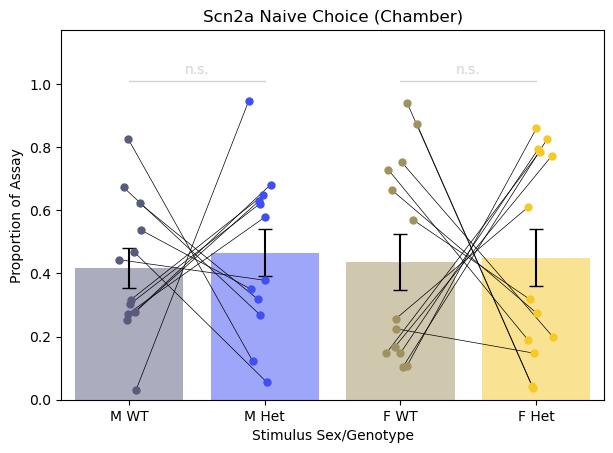

In [4]:
NC_side = NC_StatGraph_new(NC_chambertime,'side',mode='paired')

In [ ]:
# bar plot
# - significance
# - error bar
# - color
# - labels
# - bar and dots parameters

# paired bar plot

In [6]:
mpl.rcParams['lines.linewidth'] = 2

mpl.rcParams['axes.titlesize'] = 7
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['xtick.labelsize'] = 5
mpl.rcParams['ytick.labelsize'] = 5

In [10]:
data_df = NC_chambertime.copy()
        
metric = 'prop'
wt_col = 'WT_'+metric
het_col = 'HT_'+metric
side_or_huddle_word = 'Chamber'
na_column = "Unknown_sec"
acols = [[0.627451,   0.57254905, 0.37254903], # all colors
    [0.9607843,  0.7882353,  0.15294118],
    [0.34901962, 0.35686275, 0.49019608],
    [0.24705882, 0.30588236, 0.9607843 ]]

fcols = acols[0:2] # female colors, WT first
mcols = acols[2:] # male colors, WT first   

# Exclude rows that don't meet NA criteria and are sex-specific
male_df = pd.DataFrame({'WT': data_df[(data_df['Het_Sex']=='M')& (data_df[na_column]<60)][wt_col], 
                            'Het': data_df[(data_df['Het_Sex']=='M')& (data_df[na_column]<60)][het_col]})

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2640866527.py, line 25)

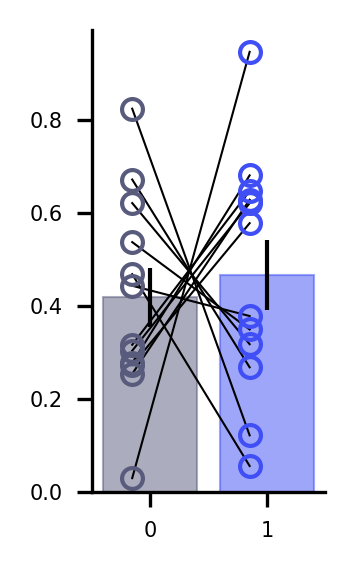

In [46]:
csz = 0
ewd = 1
dotadj = -0.15
ebaradj = 0.15
barline = 0.5

ebarspec = {'capsize':csz,'capthick':ewd,'elinewidth':ewd}


acols = [[0.627451,   0.57254905, 0.37254903], # all colors
    [0.9607843,  0.7882353,  0.15294118],
    [0.34901962, 0.35686275, 0.49019608],
    [0.24705882, 0.30588236, 0.9607843 ]]

fcols = acols[0:2] # female colors, WT first
mcols = acols[2:] # male colors, WT first 

df = male_df.copy()
cols = mcols

fig, ax = plt.subplots(figsize=(1, 2), dpi=300)
# for df, df_jitter, cols, wt_x in zip([male_df,female_df],[df_m_jitter,df_f_jitter],[mcols,fcols],[0,2]):
ax.plot(np.zeros(df.shape[0])+dotadj, df['WT'], 'o', markerfacecolor='none' , markeredgecolor =cols[0],zorder=1, ms=5, mew=1, alpha = 1)
ax.bar(0, np.mean(male_df['WT']), color = cols[0], edgecolor = cols[0], yerr = scipy.stats.sem(df['WT']),
       ecolor = 'k', capsize = csz,linewidth = barline, zorder=-1, alpha = 0.5, label=('WT'),error_kw=ebarspec)
ax.plot(np.ones(df.shape[0])+dotadj, df['Het'], 'o', markerfacecolor='none' , markeredgecolor =cols[1],zorder=1, ms=5, mew=1, alpha = 1)
ax.bar(1, np.mean(df['Het']), color = cols[1], edgecolor = cols[1], yerr = scipy.stats.sem(df['Het']), 
       ecolor = 'k', capsize = csz,linewidth = barline, zorder=-1, alpha = 0.5, label=('Het'),error_kw=ebarspec)

for idx in df.index: ax.plot([0+dotadj,1+dotadj], df.loc[idx,['WT','Het']], color = 'k', linewidth = 0.5, linestyle = '-', zorder=-1)
# for idx in male_df.index: ax.plot(df_m_jitter.loc[idx,['Left','Right']], male_df.loc[idx,['Left','Right']], color = 'k', linewidth = 0.5, linestyle = '-', zorder=-1)



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

# use errorbar object to put errorbars off center

In [43]:
df

,WT,Het
NC1,0.029535,0.946579
NC2,0.671845,0.267866
NC19,0.468327,0.055644
NC20,0.272762,0.577947
NC22,0.621212,0.317625
NC24,0.537222,0.349351
NC25,0.316438,0.647244
NC29,0.824261,0.121551
NC30,0.253782,0.628464
NC31,0.443353,0.378218
